In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [7]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape

SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 50
NUM_HIDDEN = 32
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = 0

RADI = torch.ones(1) * 2.0
NOISE_SIGMA = torch.ones(1) * 0.5
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
if CUDA:
    RADI = RADI.cuda().to(DEVICE)
    NOISE_SIGMA = NOISE_SIGMA.cuda().to(DEVICE)
    lg2pi = lg2pi.cuda().to(DEVICE)
PATH = 'ag-phase3-rws'

In [8]:
from local_enc_angle import *
from decoder import *
# initialization
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
dec_x = Dec_x(2, NUM_HIDDEN)

if CUDA:
    enc_angle.cuda().to(DEVICE)
    dec_x.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(enc_angle.parameters())+list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    ELBO = 0.0
    EUBO = 0.0
    ESS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
#         optimizer_theta.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        angle = ANGLE[batch_indices]
        mu = MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        shuffled = shuffler(torch.cat((ob, state), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        
        if CUDA:
            shuffled = shuffled.cuda().to(DEVICE)
            mu = mu.cuda().to(DEVICE)
        ob = shuffled[:, :, :, :2]
        state = shuffled[:, :, :, 2:]
        q, p = enc_angle(ob, state, mu)
        angle = p['angles'].value * 2 * math.pi
        p_recon = dec_x(ob, state, angle, mu, NOISE_SIGMA)
        ll = p_recon['likelihood'].log_prob.sum(-1)
        log_p = p['angles'].log_prob.sum(-1) - lg2pi + ll
        log_q =  q['angles'].log_prob.sum(-1) - lg2pi
        log_w = log_p.detach() - log_q
        w = torch.softmax(log_w, 0).detach()
        loss_phi = (w.detach() * (- log_q)).sum(0).sum(-1).mean()
#         loss_theta = (w * (- log_p)).sum(0).sum(-1).mean()
#         loss_phi = (- log_q).sum(-1).mean()
        loss_theta = (w.detach() * (- log_p)).sum(0).sum(-1).mean() 
        elbo = log_w.sum(-1).mean().detach()
        eubo = (w * log_w).sum(0).sum(-1).mean().detach()
        ess = (1 / (w ** 2).sum(0)).mean()
#         eubo = log_w.sum(-1).mean().detach()
        loss_phi.backward(retain_graph=True)
        loss_theta.backward()
        optimizer.step()
#         loss_theta.backward()
#         optimizer_theta.step()                      
        ELBO += elbo.detach()
        EUBO += eubo.detach()
        ESS += ess
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

epoch=0, eubo=-2315.5967, elbo=-2723.8889, ess=5.6678 (10s)
epoch=1, eubo=-789.6315, elbo=-1251.4437, ess=5.9473 (8s)
epoch=2, eubo=-553.8892, elbo=-1088.7740, ess=6.2732 (7s)
epoch=3, eubo=-484.6004, elbo=-967.9940, ess=6.8147 (7s)
epoch=4, eubo=-462.9731, elbo=-795.7654, ess=7.8617 (7s)
epoch=5, eubo=-466.5493, elbo=-752.4713, ess=8.1598 (7s)
epoch=6, eubo=-468.1503, elbo=-733.2906, ess=8.2702 (7s)


KeyboardInterrupt: 

In [ ]:
# torch.save(enc_angle.state_dict(), '../results/enc-angle-' + PATH)
# torch.save(dec_x.state_dict(), '../results/dec-x-' + PATH)

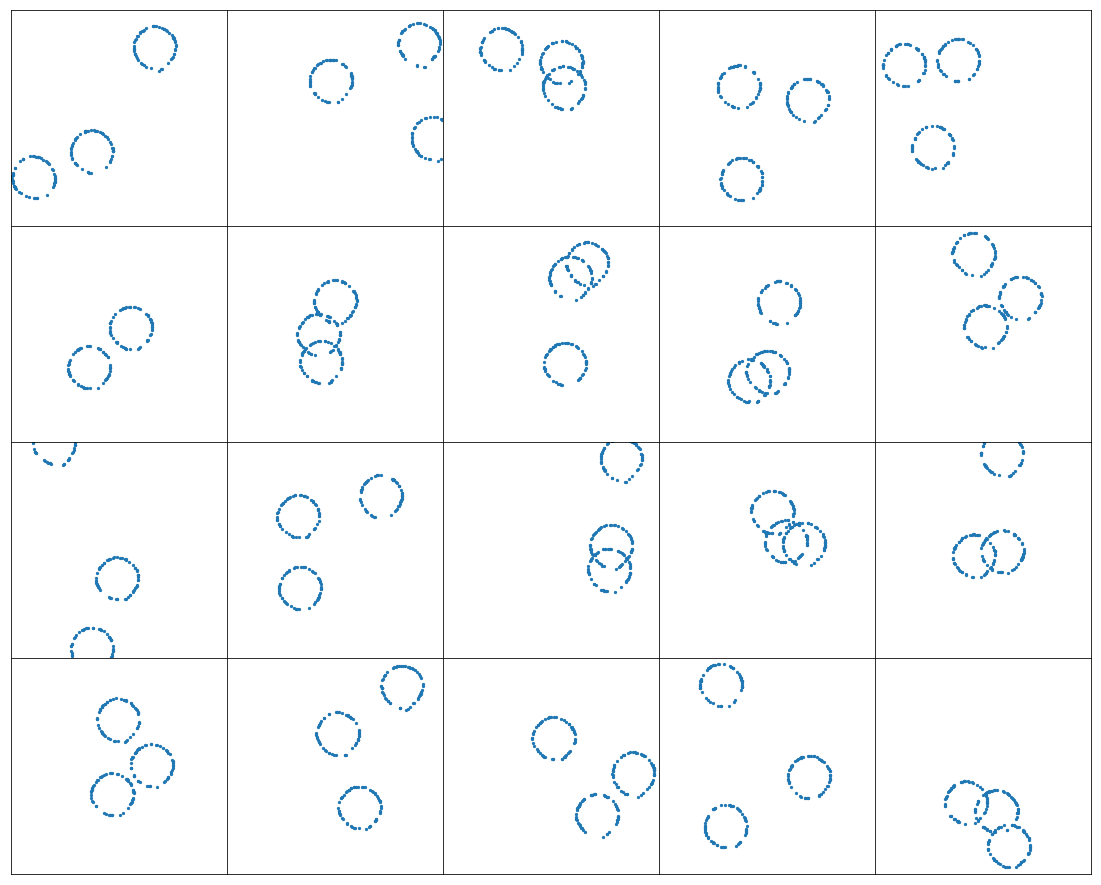

In [9]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
mu = MU[batch_indices]
angle_true = ANGLE[batch_indices]

mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
shuffled = shuffler(torch.cat((ob, state, angle_true), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    shuffled = shuffled.cuda().to(DEVICE)
    mu = mu.cuda().to(DEVICE)
ob = shuffled[:, :, :, :2]
state = shuffled[:, :, :, 2:-1]
angle_true = shuffled[:,:,:,-1].unsqueeze(-1)
# ob_mu = ob - global_to_local(mu, state)
# p_angle_samples = Normal(angle_true, QUASI_SIGMA).sample() % (2 * math.pi)
# p_angle_samples[p_angle_samples==0.0] = 1e-6
q, p = enc_angle(ob, state, mu)
# q_angle = Beta(q['angles'].dist.concentration0, q['angles'].dist.concentration1)
# beta_samples = q_angle.sample()
angle = q['angles'].value * 2 * math.pi
p_recon = dec_x(ob, state, angle, mu, NOISE_SIGMA)
recon_mu = p_recon['likelihood'].dist.loc.cpu().data.numpy()
plot_recon(recon_mu, PATH, 15, 10)

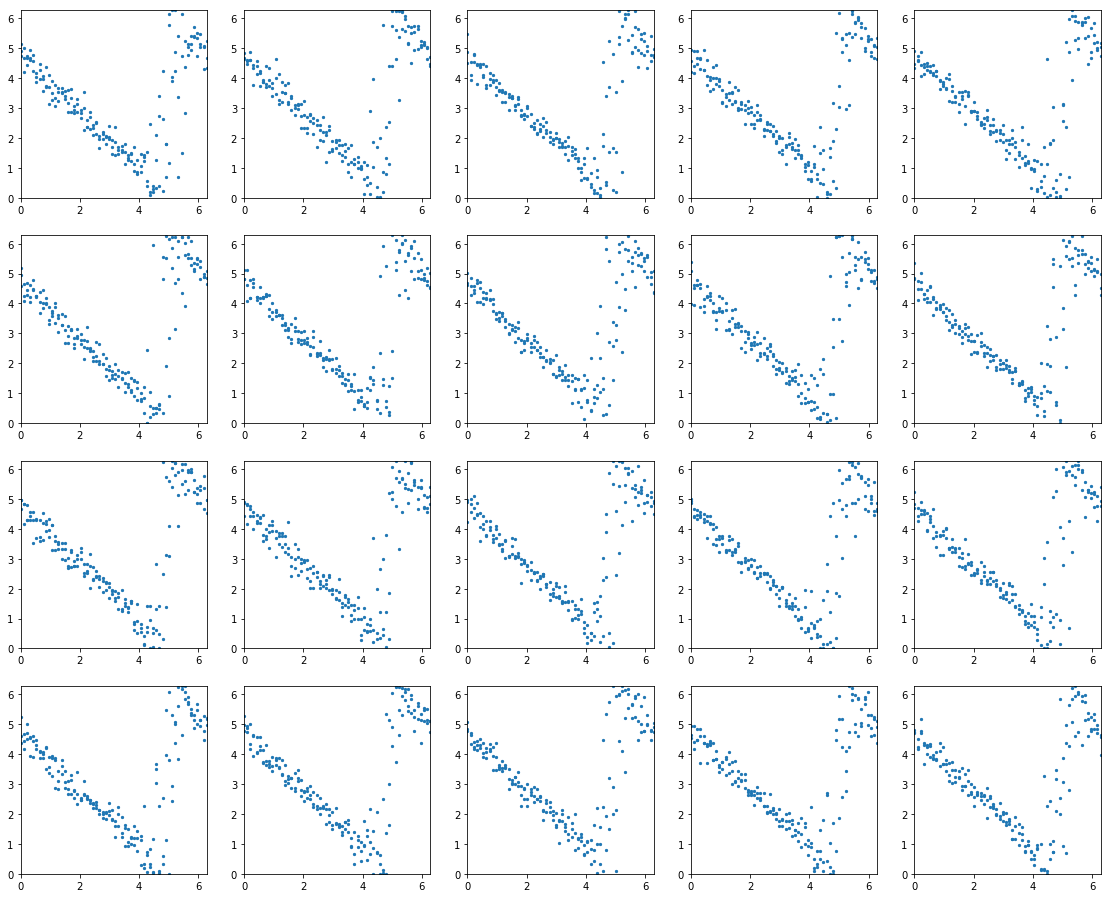

In [10]:
plot_angles(angle, angle_true, 15)